In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn


## loading Data

In [2]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [3]:
train_data = datasets.MNIST(root="data",train=True,download=True,transform=ToTensor(),target_transform = None)
test_data = datasets.MNIST(root="data",train=False,download=True,transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46237516.36it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 7276728.17it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12898932.03it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8856591.71it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
image,label = train_data[0]
# image,label
image.shape

torch.Size([1, 28, 28])

In [5]:
# Checking for sample size of test and train data
len(train_data.data),len(train_data.targets),len(test_data.data),len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Visualizing the Data

Image Shape : torch.Size([1, 28, 28])


Text(0.5, 1.0, '5')

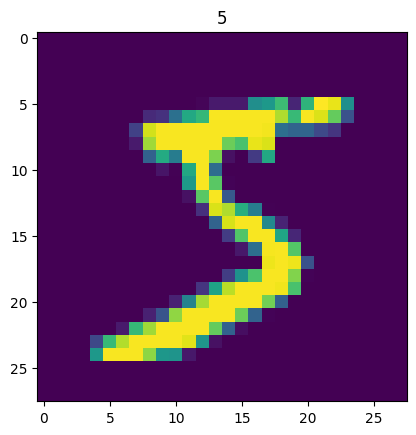

In [7]:
image,label = train_data[0]
print(f"Image Shape : {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

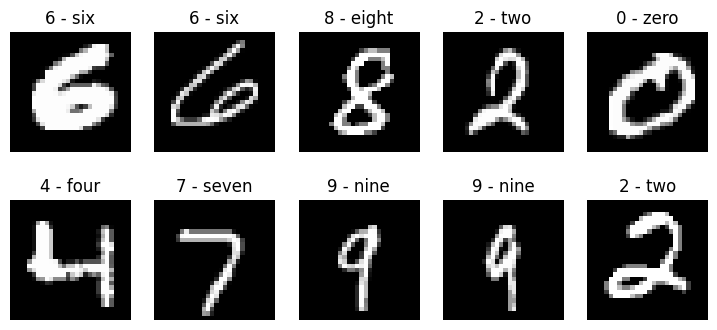

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,4))
rw,cl = 2,5
for i in range(1,rw*cl+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rw,cl,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## Prepping Dataloader

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

print(f"Dataloaders : {train_dataloader,test_dataloader}")
print(f"Length of train dataloader : {len(train_dataloader)} and Length of test dataloader : {len(test_dataloader)}")
print(f"Number of batches in train dataloader : {BATCH_SIZE} and Number of batches in test dataloader : {BATCH_SIZE}")

Dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x7f5dd92924a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f5dd92925c0>)
Length of train dataloader : 1875 and Length of test dataloader : 313
Number of batches in train dataloader : 32 and Number of batches in test dataloader : 32


## Building a CONVOLUTIONAL NUERAL NETWROK (CNN)

In [10]:
class MNISTModel(nn.Module):
  def __init__(self,input_shape:int,output_shape:int,hidden_units:int):
    super().__init__()
    self.block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2))

    self.block_2 = nn.Sequential(nn.Conv2d(hidden_units,hidden_units,3,padding=1),
    nn.ReLU(),
    nn.Conv2d(hidden_units,hidden_units,3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2))

    self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(in_features=hidden_units*7*7,out_features=output_shape))

  def forward(self,x:torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)

model_0 = MNISTModel(input_shape=1,output_shape=len(class_names),hidden_units=10)
model_0



MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [11]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
# Setting up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

## Training and testing Model

In [13]:
def train_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn):
  train_loss,train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} and Train accuracy : {train_acc:.2f}%")



In [14]:
def test_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      test_pred = model(X)
      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss : {test_loss:.5f} and Test accuracy : {test_acc:.2f}%")

In [15]:
def eval_model(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn):
  loss,acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      test_pred = model(X)
      loss += loss_fn(test_pred,y)
      acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [16]:
import tqdm
torch.manual_seed(42)

epochs = 3

for epoch in tqdm.tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n--------------")
  train_step(model=model_0,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn)
  test_step(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
--------------
Train loss : 0.33561 and Train accuracy : 88.74%


 33%|███▎      | 1/3 [01:10<02:20, 70.35s/it]

Test loss : 0.07362 and Test accuracy : 97.71%
Epoch : 1
--------------
Train loss : 0.08217 and Train accuracy : 97.44%


 67%|██████▋   | 2/3 [02:07<01:02, 62.54s/it]

Test loss : 0.06596 and Test accuracy : 97.95%
Epoch : 2
--------------
Train loss : 0.06436 and Train accuracy : 97.97%


100%|██████████| 3/3 [03:02<00:00, 60.99s/it]

Test loss : 0.05947 and Test accuracy : 98.04%


In [17]:
model_results = eval_model(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
model_results

{'model_name': 'MNISTModel',
 'model_loss': 0.05947470664978027,
 'model_acc': 98.04313099041534}

## Using the model to make predictions

In [18]:
def make_predictions(model:torch.nn.Module,data:list):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
      pred_probs.append(pred_prob)
  return torch.stack(pred_probs)

In [19]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k=9):
  test_samples.append(sample)
  test_labels.append(label)
print(f"Test samples : {test_samples[0].shape}")
print(f"Test labels : {test_labels[0]}")
print(f"Test sample label : {class_names[test_labels[0]]}")

Test samples : torch.Size([1, 28, 28])
Test labels : 2
Test sample label : 2 - two


In [20]:
pred_probs = make_predictions(model=model_0,data=test_samples)
pred_probs[:2]

tensor([[9.5611e-11, 5.2553e-07, 1.0000e+00, 1.3429e-07, 2.3216e-14, 1.6182e-15,
         1.1093e-13, 6.9319e-09, 1.7391e-06, 1.2477e-10],
        [1.3504e-07, 9.9834e-01, 1.5989e-06, 5.4371e-08, 6.9274e-06, 7.8727e-04,
         2.2412e-04, 2.4924e-07, 6.1812e-04, 1.8624e-05]])

In [21]:
pred_classes = torch.argmax(pred_probs,dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [22]:
test_labels,pred_classes

([2, 1, 2, 4, 6, 6, 4, 9, 1], tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]))

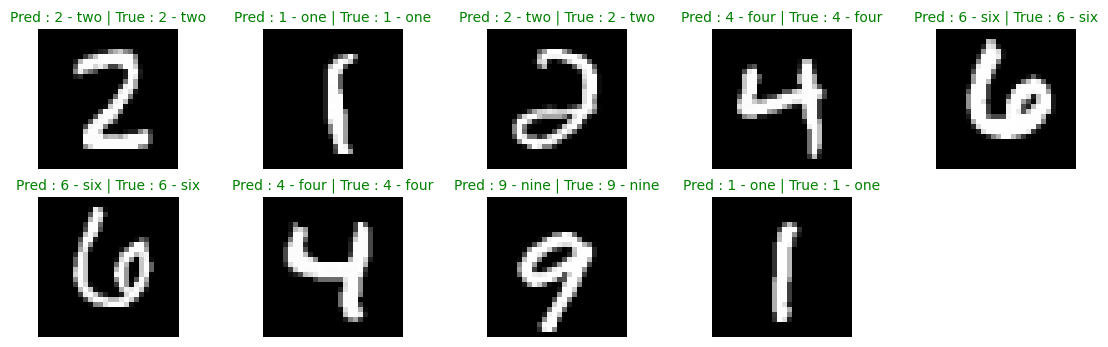

In [23]:
plt.figure(figsize=(14,4))
rws = 2
cls = 5
for i,sample in enumerate(test_samples):
  plt.subplot(rws,cls,i+1)
  plt.imshow(sample.squeeze(),cmap="gray")
  pred_label = class_names[pred_classes[i]]
  true_label = class_names[test_labels[i]]
  title_text = f"Pred : {pred_label} | True : {true_label}"
  if pred_label == true_label:
    plt.title(title_text,fontsize=10,c="green")
  else:
    plt.title(title_text,fontsize=10,c="red")
  plt.axis(False)

## Plotting a confusion matric to evaluate the model predictions

In [24]:
from tqdm.auto import tqdm

y_preds = []
model_0.eval
with torch.inference_mode():
  for X,y in tqdm(test_dataloader,desc = "Making Predictions"):
    y_logits = model_0(X)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    y_preds.append(y_pred)
y_pred_tensor = torch.cat(y_preds)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [25]:
import mlxtend
mlxtend.__version__

'0.23.1'

In [26]:
!pip install torchmetrics==0.9.3

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

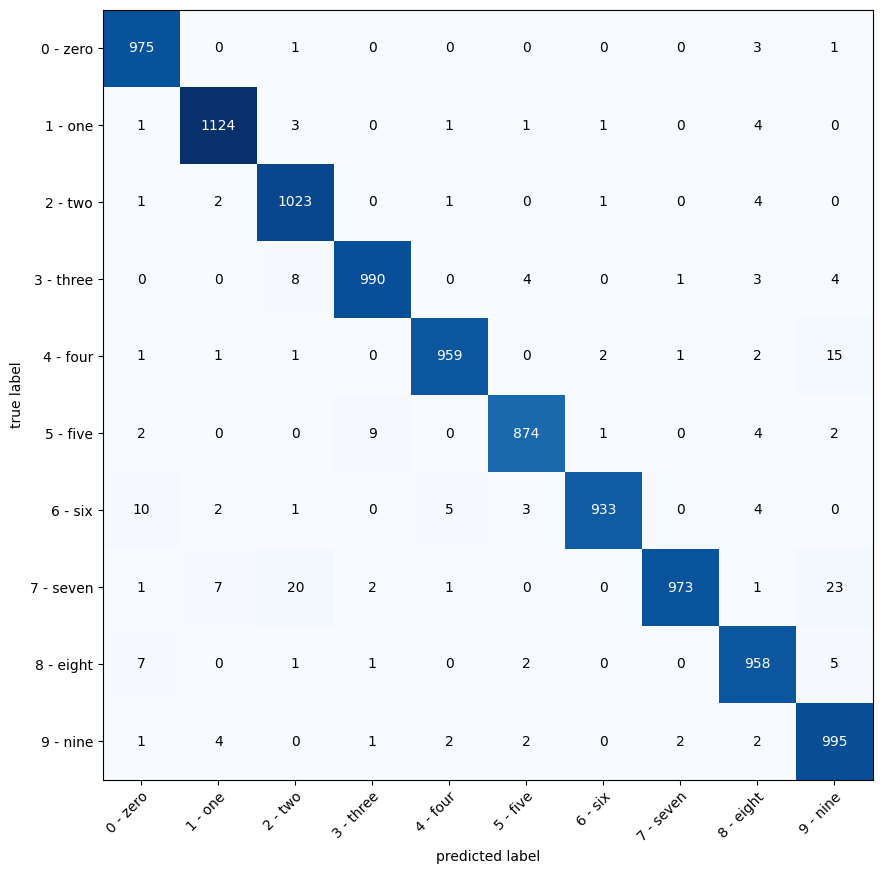

In [27]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cofmat = ConfusionMatrix(num_classes=len(class_names),task="multiclass")
cofmat_tensor = cofmat(y_pred_tensor,test_data.targets)

fx,ax = plot_confusion_matrix(conf_mat=cofmat_tensor.numpy(),figsize=(10,10),class_names=class_names)

## Saving and loading the Model

In [28]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "mnist_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)


Saving model to : models/mnist_model.pth


In [29]:
loaded_model_0 = MNISTModel(input_shape=1,output_shape=len(class_names),hidden_units=10)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
torch.manual_seed(42)

loaded_model_0_results = eval_model(model=loaded_model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)
loaded_model_0_results

{'model_name': 'MNISTModel',
 'model_loss': 0.05947470664978027,
 'model_acc': 98.04313099041534}

In [31]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(loaded_model_0_results["model_loss"]),torch.tensor(model_results["model_loss"]),atol=1e-08,rtol=1e-05)

tensor(True)

## Understanding hyperparameters


In [32]:
# creating a random tensor
torch.manual_seed(42)

images = torch.randn(size=(1,3,64,64))
test_image = images[0]
images.shape,test_image.shape

(torch.Size([1, 3, 64, 64]), torch.Size([3, 64, 64]))

In [33]:
test_image

tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978,  1.0261,  1.1465,  ...,  1.2134,  0.9354, -0.0780],
         [-1.4647, -1.9571,  0.1017,  ..., -1

In [34]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1,padding=1)
conv_layer.weight.shape

torch.Size([10, 3, 3, 3])

In [35]:
conv_layer(test_image)

tensor([[[ 1.3047,  1.4238,  0.9435,  ...,  0.3078,  0.4244, -0.3909],
         [ 0.6132,  1.5396,  0.0516,  ...,  0.8711,  0.4256, -0.3416],
         [ 1.0524,  0.3662,  1.0114,  ...,  0.2809, -0.2741,  0.3787],
         ...,
         [ 0.0377,  0.2981, -0.2432,  ..., -0.7283, -0.5767, -0.0783],
         [-0.2693, -0.0386, -0.0781,  ...,  0.4228, -0.1802, -0.5140],
         [ 0.5006, -0.5684,  0.1166,  ...,  0.5425, -0.3335,  0.7756]],

        [[-0.1153,  0.5129, -0.7227,  ..., -0.6758,  0.4840, -0.8125],
         [ 0.2266, -0.2840, -0.0319,  ...,  1.5599, -1.2449, -0.4410],
         [-0.6666,  0.2753, -0.1262,  ...,  0.1999, -0.8856, -0.4292],
         ...,
         [-0.0647, -0.1984, -0.6386,  ..., -0.0585, -0.7833, -0.0764],
         [ 0.2940, -0.6306, -0.2052,  ...,  0.2456, -0.7134,  0.7373],
         [-0.1683, -0.8397,  0.2643,  ...,  0.2593, -0.5630,  0.1587]],

        [[ 0.4864, -0.7476, -0.6414,  ...,  0.5477, -1.2156,  0.2989],
         [-0.5791,  0.4414,  0.5100,  ...,  0

In [36]:
torch.manual_seed(42)
conv_layer_v1 = nn.Conv2d(in_channels=3,out_channels=10,kernel_size=5,stride=1,padding=1)
conv_layer_v1.weight.shape

torch.Size([10, 3, 5, 5])

In [37]:
conv_layer_v1(test_image)

tensor([[[ 0.4772,  0.5412,  0.1020,  ...,  0.3054,  0.7428, -0.6291],
         [ 0.6307, -0.5948,  0.5159,  ...,  0.4623, -0.6036,  0.2882],
         [-0.1225,  0.3460, -0.1724,  ...,  0.5209,  1.3144,  0.5093],
         ...,
         [-0.4374, -0.8416,  0.1119,  ..., -0.6631,  0.4715,  0.1906],
         [ 0.4695,  1.0285,  1.5175,  ..., -0.7155, -0.8667, -0.1813],
         [-0.3646,  0.2086, -0.0867,  ..., -0.0119,  0.0038, -0.0834]],

        [[ 0.4346, -0.7569, -0.3307,  ..., -0.0755,  0.6692,  0.4795],
         [-0.0036,  0.1400, -1.2239,  ..., -0.7517,  1.1006, -0.6558],
         [ 1.6202, -0.4693,  0.4681,  ...,  1.1656, -0.2948,  0.7524],
         ...,
         [-1.0973, -0.6935, -0.6618,  ...,  0.7032, -0.2685,  0.4434],
         [ 0.2814,  0.3958,  0.9908,  ..., -1.2961, -0.6092, -0.1906],
         [ 0.4268, -0.4845,  0.3031,  ..., -0.3548, -0.0345, -0.4605]],

        [[-0.2106, -0.3158, -0.3174,  ..., -0.2237, -0.1806,  0.0684],
         [ 0.8027,  1.7556, -1.0250,  ..., -0